<a href="https://colab.research.google.com/github/Mohamadaminlotfi98/Spike-Sorting-with-Diffrent-deep-learning-models/blob/main/Clustering_with_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as t
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import scipy.io as sio
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import math
from sklearn import metrics
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import silhouette_score
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture

In [ ]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pymatreader import read_mat
data = read_mat('Simulator/C_Difficult1_noise005.mat')

In [ ]:
spike_class = data['spike_class'][0][:]
spike_data = data['data']
spike_times = data['spike_times']

Number of overlapped waveforms: (767, 40)
Number of non-overlapping waveforms: (2616, 40)
Number of overlapped labels: (767,)
Number of non-overlapping labels: (2616,)


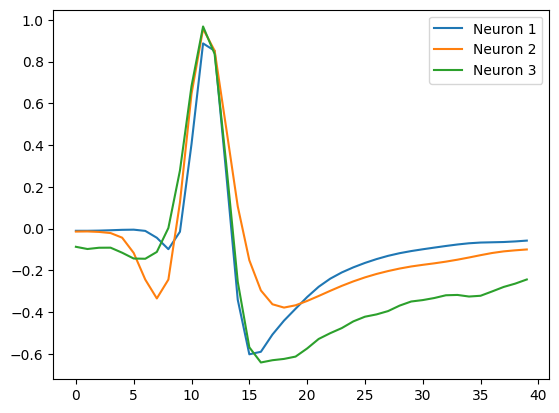

In [ ]:
waveform_length = 40
forward = 10
all_waveforms = np.zeros((len(spike_times), waveform_length))
for i, spike_time in enumerate(spike_times):
    waveform = data['data'][spike_time+forward : spike_time + waveform_length+forward]
    all_waveforms[i] = waveform
overlapped_waveforms = np.zeros((len(spike_times), waveform_length))
non_overlapping_waveforms = np.zeros((len(spike_times), waveform_length))
overlapped_labels = np.zeros(len(spike_times))
non_overlapping_labels = np.zeros(len(spike_times))
for i, spike_time in enumerate(spike_times):
    if data['spike_class'][1][i] == 0:
        non_overlapping_waveforms[i] = all_waveforms[i]
        non_overlapping_labels[i] = data['spike_class'][0][i]
    else:
       overlapped_waveforms[i] = all_waveforms[i]
       overlapped_labels[i] = data['spike_class'][0][i]
overlapped_waveforms = np.array(overlapped_waveforms[~np.all(overlapped_waveforms == 0, axis=1)])
non_overlapping_waveforms = np.array(non_overlapping_waveforms[~np.all(non_overlapping_waveforms == 0, axis=1)])
non_zero_mask = non_overlapping_labels != 0
non_overlapping_labels = non_overlapping_labels[non_zero_mask]
non_zero_mask = overlapped_labels != 0
overlapped_labels = overlapped_labels[non_zero_mask]
spike_curve_zscore = (non_overlapping_waveforms - np.mean(non_overlapping_waveforms, axis=1, keepdims=True)) / np.std(non_overlapping_waveforms, axis=1, keepdims=True)
print(f'Number of overlapped waveforms: {(overlapped_waveforms.shape)}')
print(f'Number of non-overlapping waveforms: {(non_overlapping_waveforms.shape)}')
print(f'Number of overlapped labels: {(overlapped_labels.shape)}')
print(f'Number of non-overlapping labels: {(non_overlapping_labels.shape)}')
unique_labels = np.unique(spike_class)
mean_waveforms = []
for label in unique_labels:
    mean_waveform = np.mean(all_waveforms[spike_class == label], axis=0)
    mean_waveforms.append(mean_waveform)
for i, waveform in enumerate(mean_waveforms):
    plt.plot(waveform, label=f'Neuron {i+1}')
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


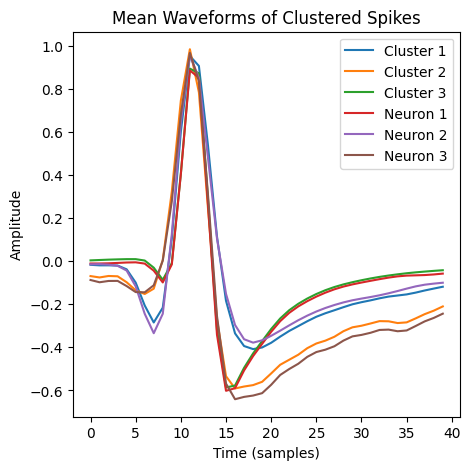

In [ ]:
waveforms_std = (non_overlapping_waveforms - np.mean(non_overlapping_waveforms, axis=1, keepdims=True)) / np.std(non_overlapping_waveforms, axis=1, keepdims=True)
pca = PCA(n_components=2)
low_dim = pca.fit_transform(waveforms_std)
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(low_dim)

mean_waves = []
for i in range(3):
    mean_wave = np.mean(non_overlapping_waveforms[kmeans_labels == i], axis=0)
    mean_waves.append(mean_wave)

# Assign KMeans labels based on waveform correlation with cluster means
for i in range(len(non_overlapping_waveforms)):
    corr_coeffs = [np.corrcoef(non_overlapping_waveforms[i], mean_wave)[0, 1] for mean_wave in mean_waves]
    assigned_label = np.argmax(corr_coeffs)
    kmeans_labels[i] = assigned_label+1
plt.figure(figsize=(5,5))
for i in range(3):
    plt.plot(mean_waves[i], label='Cluster {}'.format(i+1))
for i, waveform in enumerate(mean_waveforms):
    plt.plot(waveform, label=f'Neuron {i+1}')
plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Mean Waveforms of Clustered Spikes')
plt.show()

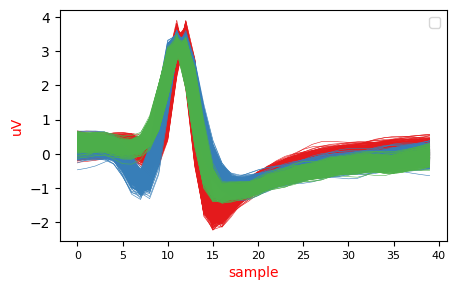

In [ ]:
plt.figure(figsize=(5,3))
for i, cluster_id in enumerate(np.unique(non_overlapping_labels)):
    spikes_cluster = waveforms_std[non_overlapping_labels == cluster_id]
    color = plt.cm.Set1(i)
    label = None if i > 0 else f'Cluster {cluster_id}'
    for spike in spikes_cluster:
        plt.plot(spike, linewidth=0.4, color=color)
        label = None
plt.xticks(fontsize=8)
plt.xlabel('sample', color='red')
plt.ylabel('uV', color='red')
plt.legend()
plt.show()

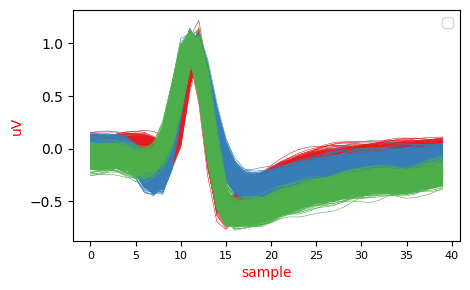

In [ ]:
plt.figure(figsize=(5,3))
for i, cluster_id in enumerate(np.unique(non_overlapping_labels)):
    spikes_cluster = non_overlapping_waveforms[non_overlapping_labels == cluster_id]
    color = plt.cm.Set1(i)
    label = None if i > 0 else f'Cluster {cluster_id}'
    for spike in spikes_cluster:
        plt.plot(spike, linewidth=0.4, color=color)
        label = None
plt.xticks(fontsize=8)
plt.xlabel('sample', color='red')
plt.ylabel('uV', color='red')
plt.legend()
plt.show()

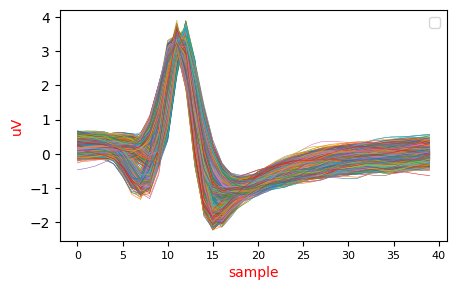

In [ ]:
plt.figure(figsize=(5,3))
for spike in waveforms_std :
        plt.plot(spike, linewidth=0.4)
        # Only show the label for the first spike in the cluster
        label = None
plt.xticks(fontsize=8)
plt.xlabel('sample', color='red')
plt.ylabel('uV', color='red')
plt.legend()
plt.show()

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.2 MB/s eta 0:00:00


In [ ]:
class TransformerSpikeSorter(nn.Module):
    def __init__(self, input_size):
        super(TransformerSpikeSorter, self).__init__()
        self.input_size = input_size
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=20, dim_feedforward=2048),
            num_layers=4)
    def forward(self, x):
        encoded = self.transformer_encoder(x)
        return encoded
# Example usage
input_size = 40  # size of input spike templates
Transformer = TransformerSpikeSorter(input_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device\n")
Transformer.to(device)
#Classifier.to(device)

The model will be running on cpu device



TransformerSpikeSorter(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
        )
        (linear1): Linear(in_features=40, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=40, bias=True)
        (norm1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
label = non_overlapping_labels
data = waveforms_std
X_train, test_data, X_label, test_label = train_test_split(data, label, test_size=0.50,shuffle = True)
# Convert the data and labels to PyTorch tensors
train_inputs = torch.from_numpy(X_train).float()
test_inputs = torch.from_numpy(test_data).float()
train_labels = torch.from_numpy(X_label).float()
test_labels = torch.from_numpy(test_label).float()
mean_waves = torch.tensor(mean_waves)
print(train_inputs.shape)
print(test_inputs.shape)
print(train_labels.shape)
print(test_labels.shape)

torch.Size([1308, 40])
torch.Size([1308, 40])
torch.Size([1308])
torch.Size([1308])


<ipython-input-11-efa9cd7245d8>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  mean_waves = torch.tensor(mean_waves)


In [ ]:
def contrastive_clustering_loss(encoded_data, num_clusters, device):
    gmm = GaussianMixture(n_components=num_clusters).fit(encoded_data.cpu().detach().numpy())
    labels = torch.as_tensor(gmm.predict(encoded_data.cpu().detach().numpy())).to(device)
    accuracy = torch.mean((labels == labels[0]).float())
    loss = -torch.log(accuracy + 1e-7)
    return loss

In [ ]:
non_overlapping_labels = torch.as_tensor(non_overlapping_labels)
waveforms_std = torch.as_tensor(waveforms_std)
data = TensorDataset(waveforms_std)
dataloader = DataLoader(data, batch_size=1024, shuffle=True)
optimizer = torch.optim.Adam(Transformer.parameters(), lr=0.001)
num_epochs = 50
num_clusters = 3
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in dataloader:
        inputs = batch[0].to(device)
        encoded_data = Transformer(inputs.float())
        loss = contrastive_clustering_loss(encoded_data, num_clusters, device)
        loss.requires_grad_()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

Epoch [1/50], Loss: 1.0298
Epoch [2/50], Loss: 1.1536
Epoch [3/50], Loss: 1.0470
Epoch [4/50], Loss: 1.0674
Epoch [5/50], Loss: 1.1246
Epoch [6/50], Loss: 1.0501
Epoch [7/50], Loss: 1.0830
Epoch [8/50], Loss: 1.0869
Epoch [9/50], Loss: 1.1719
Epoch [10/50], Loss: 1.0995
Epoch [11/50], Loss: 1.0994
Epoch [12/50], Loss: 1.1603
Epoch [13/50], Loss: 1.1736
Epoch [14/50], Loss: 1.1626
Epoch [15/50], Loss: 1.1941
Epoch [16/50], Loss: 0.9485
Epoch [17/50], Loss: 1.1036
Epoch [18/50], Loss: 1.1103
Epoch [19/50], Loss: 1.1001
Epoch [20/50], Loss: 1.1562
Epoch [21/50], Loss: 1.0227
Epoch [22/50], Loss: 1.1310
Epoch [23/50], Loss: 1.0374
Epoch [24/50], Loss: 1.0210
Epoch [25/50], Loss: 1.1318
Epoch [26/50], Loss: 1.0880
Epoch [27/50], Loss: 1.0060
Epoch [28/50], Loss: 1.2629
Epoch [29/50], Loss: 1.1090
Epoch [30/50], Loss: 1.0959
Epoch [31/50], Loss: 1.1412
Epoch [32/50], Loss: 1.0453
Epoch [33/50], Loss: 1.0681
Epoch [34/50], Loss: 1.0685
Epoch [35/50], Loss: 0.9805
Epoch [36/50], Loss: 1.1184
E

In [ ]:
# Compute PCA on input waveforms
pca = PCA(n_components=2)
pca_inputs = pca.fit_transform(waveforms_std.float().to(device).detach().cpu().numpy())
# Plot PCA of input waveforms with true labels
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(pca_inputs[:, 0], pca_inputs[:, 1], c=non_overlapping_labels.numpy())
ax[0].set_title('Input Waveforms with True Labels')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
# Compute PCA on encoded outputs
encoded_outputs = Transformer.transformer_encoder(waveforms_std.float().to(device))
pca_inputs = pca.fit_transform(encoded_outputs.float().to(device).detach().cpu().numpy())
predicted_labels = GMM(n_clusters=num_clusters, random_state=0, n_init=10).fit_predict(pca_inputs)
pca_outputs = pca.fit_transform(encoded_outputs.detach().cpu().numpy())
# Plot PCA of clustering with predicted labels
ax[1].scatter(pca_outputs[:, 0], pca_outputs[:, 1], c=predicted_labels)
ax[1].set_title('Clustering with Predicted Labels')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
plt.show()

In [ ]:
np.sum((predicted_labels+1)==non_overlapping_labels)

0

In [ ]:
predicted_labels+=1


[False]

In [ ]:
def load_data(dataset_name):
    data = read_mat('Simulator/'+dataset_name+'.mat')
    spike_class = data['spike_class'][0][:]
    spike_data = data['data']
    spike_times = data['spike_times']
    waveform_length = 40
    forward = 10
    all_waveforms = np.zeros((len(spike_times), waveform_length))
    for i, spike_time in enumerate(spike_times):
        waveform = data['data'][spike_time+forward : spike_time + waveform_length+forward]
        all_waveforms[i] = waveform
    overlapped_waveforms = np.zeros((len(spike_times), waveform_length))
    non_overlapping_waveforms = np.zeros((len(spike_times), waveform_length))
    overlapped_labels = np.zeros((len(spike_times)))
    non_overlapping_labels = np.zeros((len(spike_times)))
    for i, spike_time in enumerate(spike_times):
        if data['spike_class'][1][i] == 0:
            non_overlapping_waveforms[i] = all_waveforms[i]
            non_overlapping_labels[i] = data['spike_class'][0][i]
        else:
            overlapped_waveforms[i] = all_waveforms[i]
            overlapped_labels[i] = data['spike_class'][0][i]
    overlapped_waveforms = np.array(overlapped_waveforms[~np.all(overlapped_waveforms == 0, axis=1)])
    non_overlapping_waveforms = np.array(non_overlapping_waveforms[~np.all(non_overlapping_waveforms == 0, axis=1)])
    non_zero_mask = non_overlapping_labels != 0
    non_overlapping_labels = non_overlapping_labels[non_zero_mask]
    non_zero_mask = overlapped_labels != 0
    overlapped_labels = overlapped_labels[non_zero_mask]
    waveforms_std = (non_overlapping_waveforms - np.mean(non_overlapping_waveforms, axis=1, keepdims=True)) / np.std(non_overlapping_waveforms, axis=1, keepdims=True)
    label = non_overlapping_labels-1
    data = waveforms_std
    ti = torch.from_numpy(data).float()
    tl = torch.from_numpy(label).float()
    return ti, tl


In [ ]:
Transformer.eval()
dataset0 =[ 'C_Easy1_noise005','C_Easy1_noise01','C_Easy1_noise015','C_Easy1_noise02','C_Easy1_noise025','C_Easy1_noise03','C_Easy1_noise035','C_Easy1_noise04']
dataset1 =[ 'C_Easy2_noise005','C_Easy2_noise01','C_Easy2_noise015','C_Easy2_noise02']
dataset2 =[ 'C_Difficult1_noise005','C_Difficult1_noise01','C_Difficult1_noise015','C_Difficult1_noise02']
dataset3 =[ 'C_Difficult2_noise005','C_Difficult2_noise01','C_Difficult2_noise015','C_Difficult2_noise02']
for read in dataset2:
  test_inputs,test_labels = load_data(read)
  test_loss = 0
  correct = 0
  total = 0
  wrong_inputs = []
  wrong_predicted = []
  wrong_labels = []
  wrong_denoised_outputs = []
  with torch.no_grad():
      test_loss = 0
      correct = 0
      total = 0
      for i in range(len(test_inputs)):
          # Get inputs and labels from the test dataset
          inputs = test_inputs[i:i+1].to(device)
          labels = test_labels[i:i+1].long().to(device)
          # Forward pass
          denoised_output = Transformer(inputs)
          denoised_output = denoised_output.squeeze(0)
          # Compute cluster assignment
          correlations = []
          for i in range(mean_waves.shape[0]):
              correlation = np.corrcoef(denoised_output.cpu().numpy(), mean_waves[i, :])[0, 1]
              correlations.append(correlation)
          correlations = np.array(correlations)
          # Compute accuracy
          total += 1
          pred = torch.argmax(torch.from_numpy(correlations)).item()
          if pred == labels.item():
              correct += 1
          else:
              wrong_inputs.append(inputs.cpu().numpy())
              wrong_predicted.append(pred)
              wrong_labels.append(labels.cpu().numpy())
              wrong_denoised_outputs.append(denoised_output.cpu().numpy())
      accuracy = 100 * correct / total
      # Print results
      print('*****************')
      print(read)
      print(f'Overall Accuracy:', accuracy,'correct{}/total{}',correct,total)
# fig, axs = plt.subplots(len(wrong_inputs), 2, figsize=(8, 2*len(wrong_inputs)))
# for i in range(len(wrong_inputs)):
#       axs[i, 0].plot(wrong_inputs[i][0])
#       axs[i, 0].set_title(f"True: {wrong_labels[i]}, Predicted: {wrong_predicted[i]}")
#       axs[i, 0].axis('off')
#       axs[i, 1].plot(wrong_denoised_outputs[i][0])
#       axs[i, 1].set_title('Denoised Output')
#       axs[i, 1].axis('off')
# plt.show()

In [ ]:
import IPython
import os
import openai

openai.api_key = "please-paste-your-API-key-here"

def createImageWithGPT(prompt):
  completion = openai.Image.create(
  prompt=prompt,
  n=1,
  size="512x512"
  )
  return IPython.display.HTML("<img src =" + completion.data[0].url + ">")

In [ ]:
createImageWithGPT("Cat driving a skateboard")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(test_inputs)
# Plot the denoised data in a 3D scatter plot
# Create a scatter plot of the data points with a white background
fig = plt.figure(facecolor='white')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=test_labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()

In [ ]:
# Put the model in evaluation mode
Transformer.eval()

# Define variables for tracking accuracy and loss
test_loss = 0
correct = 0
total = 0

# Lists to store denoised outputs and their labels
denoised_outputs = []
labels = []

# Loop over the test dataset
with torch.no_grad():
    for i in range(len(test_inputs)):
        # Get inputs and labels from the test dataset
        inputs = test_inputs[i:i+1].to(device)
        # Forward pass
        denoised_output = Transformer(inputs)
        # Append the denoised output and label to their respective lists
        denoised_outputs.append(denoised_output.cpu().numpy().flatten())

# Convert the lists to numpy arrays
denoised_outputs = np.array(denoised_outputs)
labels = np.array(test_labels)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(denoised_outputs)
# Plot the denoised data in a 3D scatter plot
# Create a scatter plot of the data points with a white background
fig = plt.figure(facecolor='white')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()

In [ ]:
# Classifier.eval()
# Transformer.eval()
# dataset0 =['C_Easy1_noise005','C_Easy1_noise01','C_Easy1_noise015','C_Easy1_noise02','C_Easy1_noise025','C_Easy1_noise03','C_Easy1_noise035','C_Easy1_noise04']
# dataset1 =[ 'C_Easy2_noise005','C_Easy2_noise01','C_Easy2_noise015','C_Easy2_noise02']
# dataset2 =[ 'C_Difficult1_noise005','C_Difficult1_noise01','C_Difficult1_noise015','C_Difficult1_noise02']
# dataset3 =[ 'C_Difficult2_noise005','C_Difficult2_noise01','C_Difficult2_noise015','C_Difficult2_noise02']
# for read in dataset2:
#   data = read_mat('Simulator/'+read+'.mat')
#   spike_class = data['spike_class'][0][:]
#   spike_data = data['data']
#   spike_times = data['spike_times']
#   waveform_length = 40
#   forward = 10
#   # Initialize an empty array to store all the extracted waveforms
#   all_waveforms = np.zeros((len(spike_times), waveform_length))

#   # Loop through each spike
#   for i, spike_time in enumerate(spike_times):
#     # Get the waveform around the spike time
#     waveform = data['data'][spike_time+forward : spike_time + waveform_length+forward]
#     # Store the waveform in the array
#     all_waveforms[i] = waveform

#   # Initialize empty arrays to store the overlapped and non-overlapping waveforms
#   overlapped_waveforms = np.zeros((len(spike_times), waveform_length))
#   non_overlapping_waveforms = np.zeros((len(spike_times), waveform_length))
#   overlapped_labels = np.zeros((len(spike_times)))
#   non_overlapping_labels = np.zeros((len(spike_times)))
#   for i, spike_time in enumerate(spike_times):
#     # Check if the spike is overlapped
#     if data['spike_class'][1][i] == 0:
#         # Store the waveform in the overlapped waveforms array
#         non_overlapping_waveforms[i] = all_waveforms[i]
#         non_overlapping_labels[i] = data['spike_class'][0][i]
#     # Check if the spike is not overlapped
#     else:
#         # Store the waveform in the non-overlapping waveforms array
#        overlapped_waveforms[i] = all_waveforms[i]
#        overlapped_labels[i] = data['spike_class'][0][i]

#   # Remove any rows with all zeros (i.e. spikes that were overlapped or didn't have a waveform)
#   overlapped_waveforms = np.array(overlapped_waveforms[~np.all(overlapped_waveforms == 0, axis=1)])
#   non_overlapping_waveforms = np.array(non_overlapping_waveforms[~np.all(non_overlapping_waveforms == 0, axis=1)])
#   # create a boolean mask of non-zero labels
#   non_zero_mask = non_overlapping_labels != 0
#   # use the mask to select only the non-zero labels
#   non_overlapping_labels = non_overlapping_labels[non_zero_mask]
#   # create a boolean mask of non-zero labels
#   non_zero_mask = overlapped_labels != 0
#   # use the mask to select only the non-zero labels
#   overlapped_labels = overlapped_labels[non_zero_mask]
#   label = non_overlapping_labels-1
#   data = non_overlapping_waveforms
#   # Convert the data and labels to PyTorch tensors
#   test_inputs = torch.from_numpy(data).float()
#   test_labels = torch.from_numpy(label).float()
#   # Put the model in evaluation mode
#   # Define variables for tracking accuracy and loss
#   test_loss = 0
#   correct = 0
#   total = 0
#   # Lists to store wrong predictions
#   wrong_inputs = []
#   wrong_predicted = []
#   wrong_labels = []
#   wrong_denoised_outputs = []
#   # Loop over the test dataset
#   with torch.no_grad():
#       for i in range(len(test_inputs)):
#           # Get inputs and labels from the test dataset
#           inputs = test_inputs[i:i+1].to(device)
#           labels = test_labels[i:i+1].long().to(device)
#           # Forward pass
#           denoised_output = Transformer(inputs)
#           outputs = Classifier(denoised_output)
#           test_loss += criterion(outputs, labels).item()
#           # Compute accuracy
#           _, predicted = torch.max(outputs.data, 1)
#           total += labels.size(0)
#           correct += (predicted == labels).sum().item()
#           # print('True label:',labels,'Prediction is:',predicted)
#           # Check for wrong predictions
#           if predicted.item() != labels.item():
#               wrong_inputs.append(inputs.cpu().numpy())
#               wrong_predicted.append(predicted.item())
#               wrong_labels.append(labels.item())
#               wrong_denoised_outputs.append(denoised_output.cpu().numpy())
#   # Compute average test loss and accuracy
#   test_loss /= len(test_data)
#   test_acc = 100 * correct / total
#   # Print results
#   print('*****************')
#   print(read)
#   print('Test Accuracy: {:.2f}% ({}/{})'.format(100*correct/test_inputs.size(0) , correct, test_inputs.size(0)),"loss:{:.5f}".format(test_loss))
# # fig, axs = plt.subplots(len(wrong_inputs), 2, figsize=(8, 2*len(wrong_inputs)))
# # for i in range(len(wrong_inputs)):
# #       axs[i, 0].plot(wrong_inputs[i][0])
# #       axs[i, 0].set_title(f"True: {wrong_labels[i]}, Predicted: {wrong_predicted[i]}")
# #       axs[i, 0].axis('off')
# #       axs[i, 1].plot(wrong_denoised_outputs[i][0])
# #       axs[i, 1].set_title('Denoised Output')
# #       axs[i, 1].axis('off')
# # plt.show()

In [ ]:
# num_epochs = 20
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(Classifier.parameters(), lr=0.001)
# inputs = torch.tensor([])
# # Train the network
# for epoch in range(num_epochs):
#   training_loss = 0
#   loss_back = 0
#   for i in range(0, train_inputs.size(0)):
#     inputs = train_inputs[i:i+1].to(device)
#     labels = train_labels[i:i+1].to(device)
#     denoised_output = Transformer(inputs)
#     outputs = Classifier(denoised_output)
#     loss = criterion(outputs, labels.long())
#     training_loss += loss
#     loss_back += loss
#     if i % 100 == 0:
#         optimizer.zero_grad()
#         loss_back.backward()
#         optimizer.step()
#         loss_back = 0
#   training_loss = training_loss/train_inputs.size(0)
#   print('******************************************************************')
#   print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, training_loss))